<a href="https://colab.research.google.com/github/rockerritesh/Unsupervised/blob/master/RL_CAT_DOG_Classfier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import random

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 64 * 64, 1)  # Assuming input size is 64x64

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        return x

# Custom dataset class
class CatsDogsDataset(Dataset):
    def __init__(self, cat_dir, dog_dir, transform=None):
        self.cat_images = [os.path.join(cat_dir, img) for img in os.listdir(cat_dir) if img.endswith(('.png', '.jpg', '.jpeg','webp'))]
        self.dog_images = [os.path.join(dog_dir, img) for img in os.listdir(dog_dir) if img.endswith(('.png', '.jpg', '.jpeg', 'webp',))]
        self.data = [(img, 0) for img in self.cat_images[:10]] + [(img, 1) for img in self.dog_images[:10]]
        random.shuffle(self.data)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.float32)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [93]:
# Load dataset
cat_folder = "CAT"
dog_folder = "DOG"
dataset = CatsDogsDataset(cat_folder, dog_folder, transform=transform)

In [72]:
# Training setup
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [87]:
def train_rl():
    model.train()
    for img, label in dataset:
        img = img.unsqueeze(0)  # Add batch dimension
        label = label.unsqueeze(0).unsqueeze(1) # Add batch dimension and "channel" dimension to label

        # Iterate until correctly classified
        steps = 0
        while True:
            optimizer.zero_grad()
            output = model(img)
            # print(f"Output: {output.item()}, Label: {label.item()}")
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            predicted_class = (output.item() > 0.5) * 1  # Convert sigmoid output to class
            print(f"Predicted: {predicted_class}, Label: {label.item()}")
            steps += 1
            if predicted_class == label.item():
                break  # Move to next image once classified correctly
            if steps == 100:
                print("Too many steps")
                break

        print(f"Image classified correctly as {predicted_class}\n \n ")


In [94]:
# Start training
train_rl()

Predicted: 0, Label: 1.0
Predicted: 1, Label: 1.0
Image classified correctly as 1
 
 
Predicted: 1, Label: 0.0
Predicted: 1, Label: 0.0
Predicted: 0, Label: 0.0
Image classified correctly as 0
 
 
Predicted: 1, Label: 1.0
Image classified correctly as 1
 
 
Predicted: 1, Label: 1.0
Image classified correctly as 1
 
 
Predicted: 1, Label: 1.0
Image classified correctly as 1
 
 
Predicted: 1, Label: 0.0
Predicted: 0, Label: 0.0
Image classified correctly as 0
 
 
Predicted: 1, Label: 0.0
Predicted: 0, Label: 0.0
Image classified correctly as 0
 
 
Predicted: 1, Label: 1.0
Image classified correctly as 1
 
 
Predicted: 1, Label: 0.0
Predicted: 0, Label: 0.0
Image classified correctly as 0
 
 
Predicted: 0, Label: 0.0
Image classified correctly as 0
 
 
Predicted: 0, Label: 0.0
Image classified correctly as 0
 
 
Predicted: 0, Label: 1.0
Predicted: 0, Label: 1.0
Predicted: 0, Label: 1.0
Predicted: 0, Label: 1.0
Predicted: 0, Label: 1.0
Predicted: 1, Label: 1.0
Image classified correctly as

In [75]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def save_model(model, path='cat_dog_model.pth'):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def load_model(path='cat_dog_model.pth'):
    loaded_model = CNN()
    loaded_model.load_state_dict(torch.load(path, weights_only=True))  # Use `weights_only=True`
    loaded_model.eval()  # Set to evaluation mode
    print(f"Model loaded from {path}")
    return loaded_model

def predict_dataset(model, dataset):
    model.eval()  # Ensure model is in evaluation mode
    num_images = len(dataset)
    num_rows = (num_images + 2) // 3  # Adjust rows based on number of images, display 3 images per row
    plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure size based on number of rows

    with torch.no_grad():  # Disable gradient calculation for prediction
        for i in range(num_images):
            img, label = dataset[i]

            # Convert tensor to numpy and ensure correct shape
            img_numpy = img.cpu().numpy()

            if img_numpy.dtype != np.uint8:
                img_numpy = (img_numpy * 255).astype(np.uint8)  # Normalize if float

            if img_numpy.shape[0] == 1:  # Single-channel grayscale
                img_numpy = img_numpy.squeeze(0)  # Remove channel dimension
                img_original = Image.fromarray(img_numpy, mode="L")  # Grayscale mode
            elif img_numpy.shape[0] == 3:  # RGB image
                img_numpy = np.transpose(img_numpy, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
                img_original = Image.fromarray(img_numpy)  # Create RGB image
            else:
                raise ValueError(f"Unexpected image shape: {img_numpy.shape}")  # Handle unexpected cases

            img_tensor = img.unsqueeze(0)  # Add batch dimension for model input

            output = model(img_tensor)
            predicted_class = (output.item() > 0.5) * 1

            plt.subplot(num_rows, 3, i + 1)  # Create subplot for each image
            plt.imshow(img_original, cmap="gray" if img_numpy.ndim == 2 else None)  # Display correctly
            plt.title(f"True: {'Dog' if label.item() == 1 else 'Cat'}\nPredicted: {'Dog' if predicted_class == 1 else 'Cat'}\n{output.item()}")
            plt.xticks([])  # Remove x-axis ticks
            plt.yticks([])  # Remove y-axis ticks

    plt.tight_layout()  # Adjust layout to prevent overlapping titles
    plt.show()

Model saved to cat_dog_model.pth
Model loaded from cat_dog_model.pth


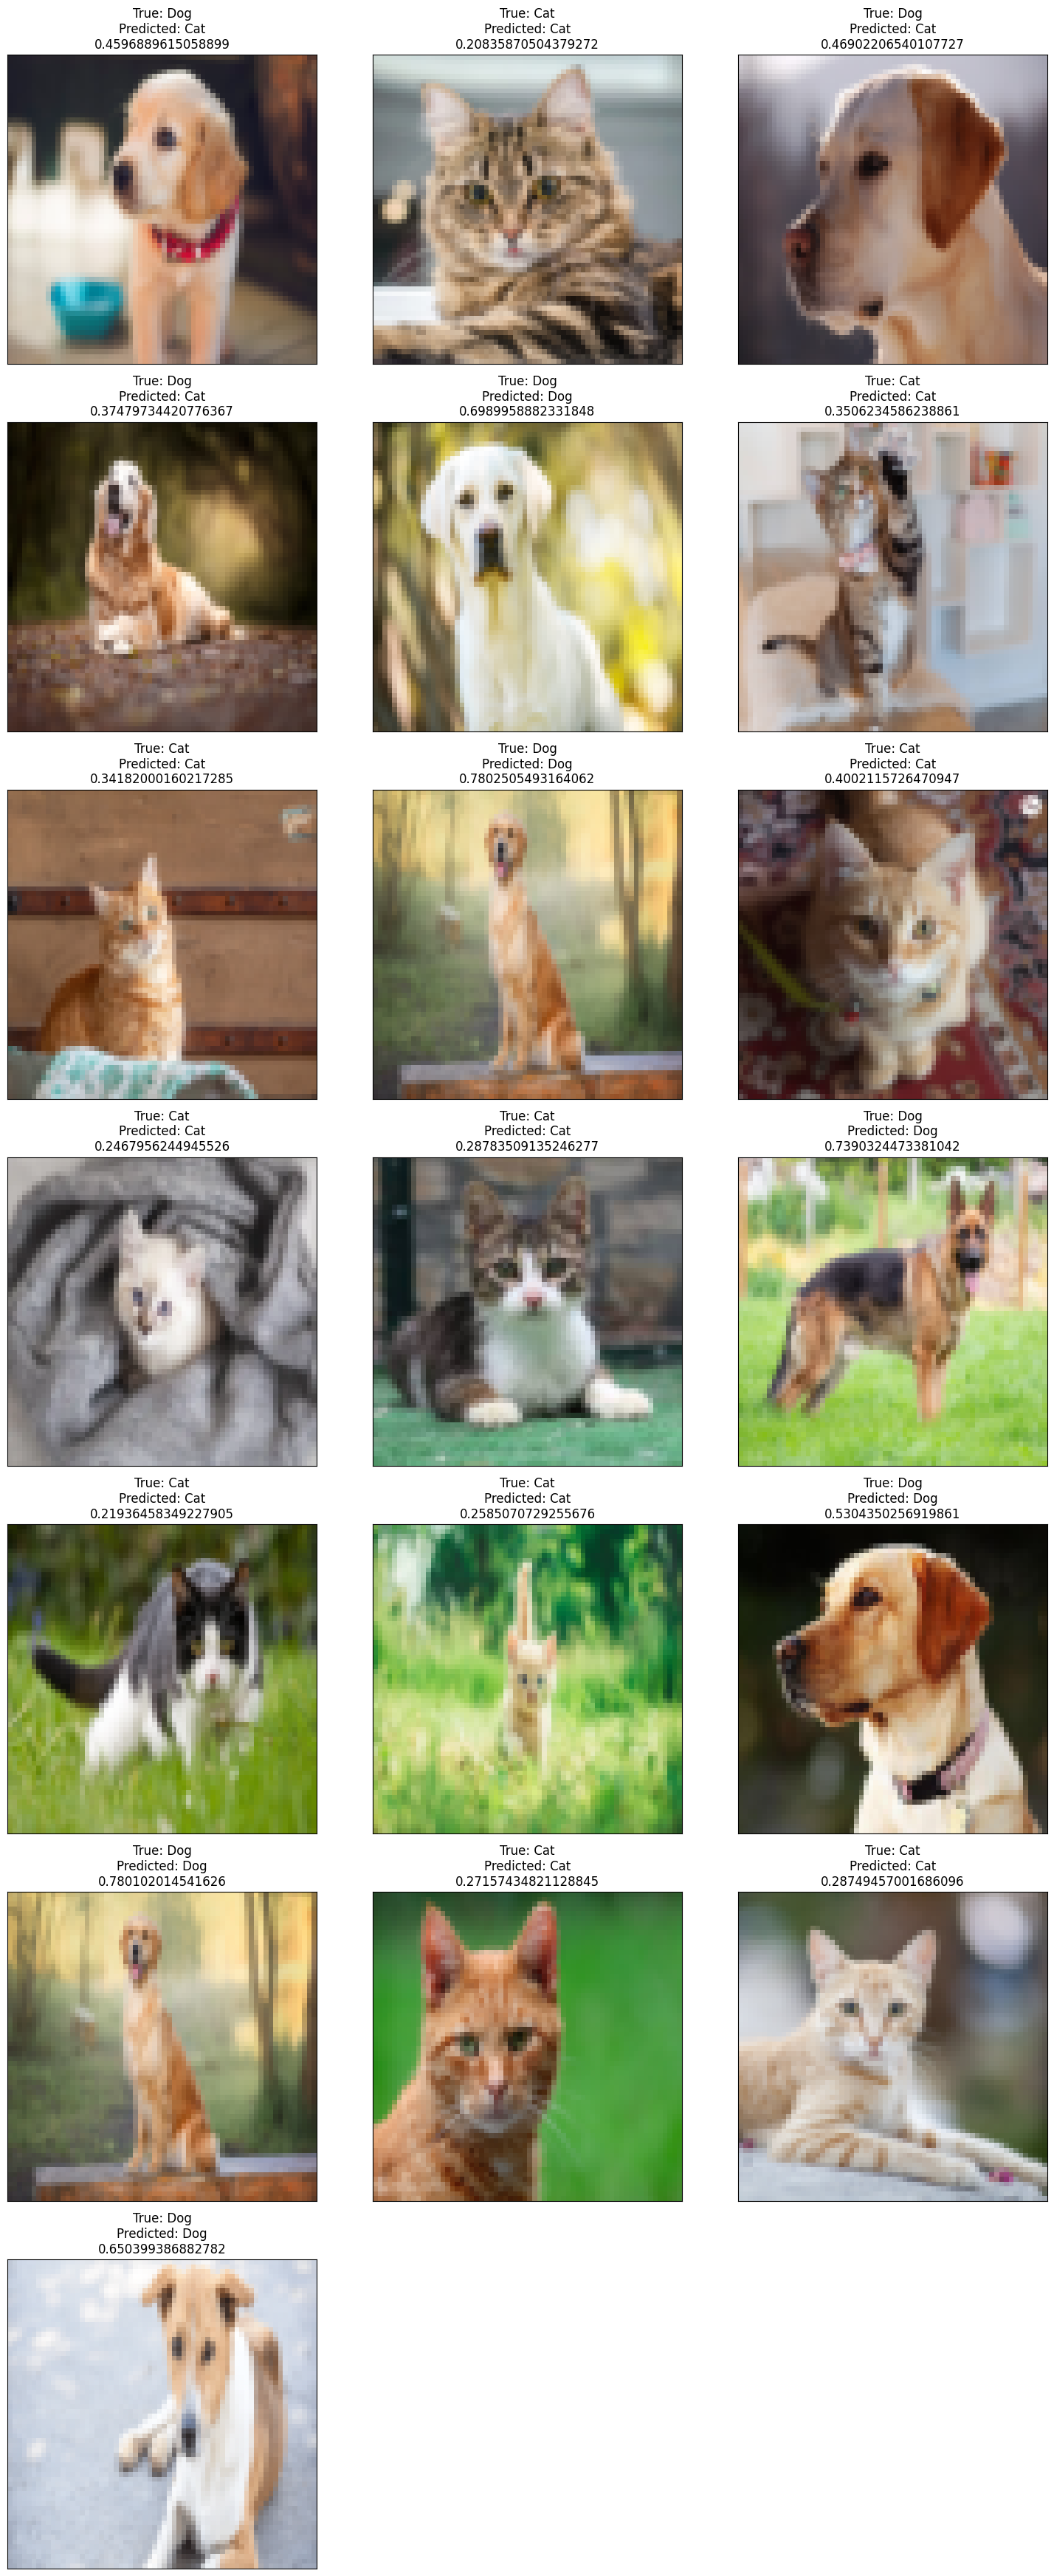

In [95]:
# save model
save_model(model)

# Load the saved model
loaded_model = load_model()

# Run prediction on the dataset and print images with labels
predict_dataset(loaded_model, dataset)

In [79]:
img = Image.open('DOG/dog1.png').convert('RGB')
# resize to 64x64
img = transform(img).unsqueeze(0)
output = model(img)
predicted_class = (output.item() > 0.5) * 1
print(f"Predicted: {'Dog' if predicted_class == 1 else 'Cat'}")
print(output.item())

Predicted: Dog
0.5071024894714355
